#                                           Group 9 / Neural Geeks
                                            Kyle Riener - 1443856
                                            Sofia Kenny -  0963051
                                            Srinivasan Vasudevan - 1455328
                                            Elva Shen -  1414646
                                            Greg Murray - 1443338
Title : Simple Question And Answering System
dataset: bAbi dataset
Date: DEC 5th 2018

In [1]:
# from __future__ import print_function
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
import tarfile
import numpy as np
import re
import os, fnmatch,glob,pathlib
from keras.layers import Bidirectional
import tensorflow as tf

/Users/srinivasanvasudevan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TEXT_DATA_DIR = '.'
path = TEXT_DATA_DIR
def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]

In [3]:
def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data

In [4]:
def get_stories(fi, only_supporting=False, max_length=None):
    '''Given a file name, read the file,
    retrieve the stories,
    and then convert the sentences into a single story.
    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    print(fi)
    f = open(fi)
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data
            if not max_length or len(flatten(story)) < max_length]
    f.close
    return data

In [5]:
def vectorize_stories(data):
    inputs, queries, answers = [], [], []
    for story, query, answer in data:
        inputs.append([word_idx[w] for w in story])
        queries.append([word_idx[w] for w in query])
        answers.append(word_idx[answer])
    return (pad_sequences(inputs, maxlen=story_maxlen),
            pad_sequences(queries, maxlen=query_maxlen),
            np.array(answers))

In [6]:
# we are going to limit train and test by 1000 each
# we will read only files that starts with qa1*
#tuple(path_.glob(pattern))
trainpattern='qa1_train.txt'
testpattern='qa1_test.txt'

trainfiles=fnmatch.filter(os.listdir(TEXT_DATA_DIR), trainpattern)
testfiles=fnmatch.filter(os.listdir(TEXT_DATA_DIR), testpattern)
for f in trainfiles:
    train_stories = get_stories(os.path.join(TEXT_DATA_DIR, f))
for f in testfiles:
    test_stories = get_stories(os.path.join(TEXT_DATA_DIR, f))

vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories)

print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')

/Users/srinivasanvasudevan/scu-study/DeepLearn/cs224n-Squad-Project-master/data/tasks_1-20_v1-2/en-valid-10k/qa1_train.txt


/Users/srinivasanvasudevan/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


/Users/srinivasanvasudevan/scu-study/DeepLearn/cs224n-Squad-Project-master/data/tasks_1-20_v1-2/en-valid-10k/qa1_test.txt
-
Vocab size: 22 unique words
Story max length: 68 words
Query max length: 4 words
Number of training stories: 9000
Number of test stories: 1000
-
Here's what a "story" tuple looks like (input, query, answer):
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'John', 'went', 'to', 'the', 'hallway', '.'], ['Where', 'is', 'Mary', '?'], 'bathroom')
-
Vectorizing the word sequences...
-
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (9000, 68)
inputs_test shape: (1000, 68)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (9000, 4)
queries_test shape: (1000, 4)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (9000,)
answers_test shape: (1000,)
-
Compiling...


### ORIGINAL with BIDIR

In [37]:
from keras import regularizers
from keras.layers import BatchNormalization
# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Bidirectional(LSTM(64, input_shape=([vocab_size, 68]))))
input_encoder_m.add(RepeatVector(68))
input_encoder_m.add(Bidirectional(LSTM(64, return_sequences=True)))
input_encoder_m.add(TimeDistributed(Dense(68)))

input_encoder_m.add(Dropout(0.3))
# output: (samples, story_maxlen, embedding_dim)


# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Bidirectional(LSTM(64, input_shape=([64, 64]))))
input_encoder_c.add(RepeatVector(68))
input_encoder_c.add(Bidirectional(LSTM(64, return_sequences=True)))
input_encoder_c.add(TimeDistributed(Dense(68)))

input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
question_encoder.add(Bidirectional(LSTM(64, input_shape=([vocab_size, 68]))))
question_encoder.add(RepeatVector(68))
question_encoder.add(Bidirectional(LSTM(68, return_sequences=True)))
question_encoder.add(TimeDistributed(Dense(68)))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
#response = Permute((1,1))(response)  # (samples, query_maxlen, story_maxlen)

# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

# the original paper uses a matrix multiplication for this reduction step.
# we choose to use a RNN instead.
answer = Bidirectional(LSTM(64, dropout=.3))(answer)  # (samples, 32)
answer = Dense(vocab_size, kernel_regularizer=regularizers.l1(.001), activation='relu')(answer)  # (samples, vocab_size)
#answer = Dropout(0.3)(answer)
answer = Dense(vocab_size, kernel_regularizer=regularizers.l2(.001))(answer)
# one regularization layer -- more would probably be needed.
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)



# (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)


# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train
history=model.fit([inputs_train, queries_train], answers_train,
          batch_size=32,
          epochs=140,
          validation_data=([inputs_test, queries_test], answers_test))

input_encoded: (?, 68, 68)
match: (?, 68, 68)
Train on 9000 samples, validate on 1000 samples
Epoch 1/140
9000/9000 [==============================] - 130s 14ms/step - loss: 2.3117 - acc: 0.1772 - val_loss: 1.7785 - val_acc: 0.2440
Epoch 2/140
9000/9000 [==============================] - 98s 11ms/step - loss: 1.8444 - acc: 0.2480 - val_loss: 1.6918 - val_acc: 0.2700
Epoch 3/140
9000/9000 [==============================] - 97s 11ms/step - loss: 1.7541 - acc: 0.2754 - val_loss: 1.6716 - val_acc: 0.3010
Epoch 4/140
9000/9000 [==============================] - 107s 12ms/step - loss: 1.7138 - acc: 0.2934 - val_loss: 1.6570 - val_acc: 0.2870
Epoch 5/140
9000/9000 [==============================] - 107s 12ms/step - loss: 1.6452 - acc: 0.3623 - val_loss: 1.5409 - val_acc: 0.3920
Epoch 6/140
9000/9000 [==============================] - 99s 11ms/step - loss: 1.5886 - acc: 0.3892 - val_loss: 1.5042 - val_acc: 0.4070
Epoch 7/140
9000/9000 [==============================] - 98s 11ms/step - loss: 1.

In [38]:
print('Evaluation')
loss, acc = model.evaluate([inputs_test, queries_test], answers_test,
                           batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))



Evaluation
1000/1000 [==============================] - 2s 2ms/step
Test loss / test accuracy = 1.3114 / 0.5420


In [32]:
import ast

def populateEncodedWordMap(embeddings_index,train_stories,inputs_train,queries_train):
    for idx in range(len(train_stories)):
        line =train_stories[idx]
        #print("line1",line)
        ak = len(line[0])
        it = inputs_train[idx]
        at= len(it)-ak
        aw = line[0]
        for i in range(len(aw)):
            embeddings_index[it[at+i]]=aw[i]
        qk = len(line[1])
        qtt = queries_train[idx]
        qt= len(qtt)-qk
        qw= line[1]
        for i in range(len(qw)):
            embeddings_index[qtt[qt+i]]=qw[i]
        

In [ ]:
embeddings_index = {}
populateEncodedWordMap(embeddings_index,train_stories,inputs_train,queries_train)


In [ ]:
testdata=test_stories[0]
test_answer=testdata[0]
test_q=testdata[1]
test_ans=testdata[2]

In [ ]:
print("Printing Sample Context (1st observation) from the test observation: ")
print(test_answer)
print(" ")
print("Printing Sample Query (1st observation) from the test observation: ",test_q)
print(" ")
print("Printing Sample Answer (1st observation) from the test observation: ",embeddings_index[answers_test[0]])
print("Now predicting...")
answers_test1=model.predict([inputs_test,queries_test])
print(" ")
print("Printing the predicted 1st observation's answer: ",embeddings_index[answers_test1[0].argmax(axis=-1)])

In [ ]:
for i in range(len(answers_test)):
    if (answers_test[i]!=answers_test1[i].argmax(axis=-1)):
        testdata=test_stories[i]
        print(i,testdata[0],embeddings_index[answers_test[i]],embeddings_index[answers_test1[i].argmax(axis=-1)])
        if(i==2): break

In [ ]:
print(train_stories[0])


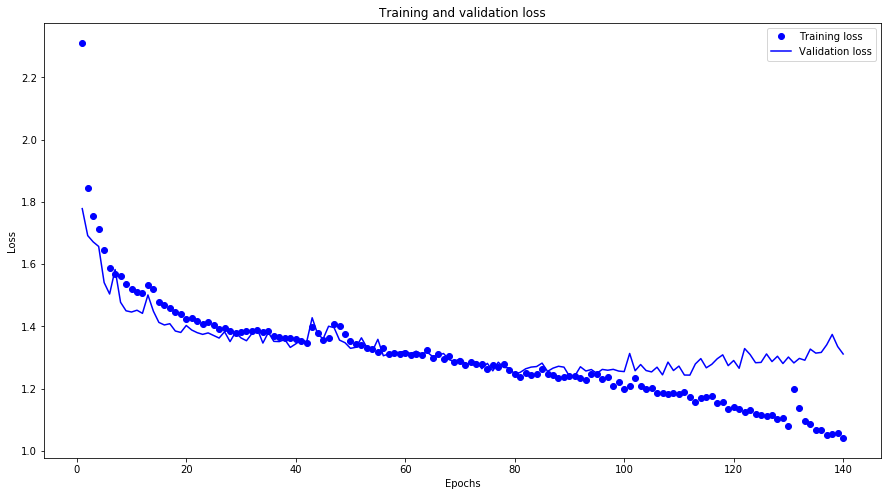

In [39]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15,8

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

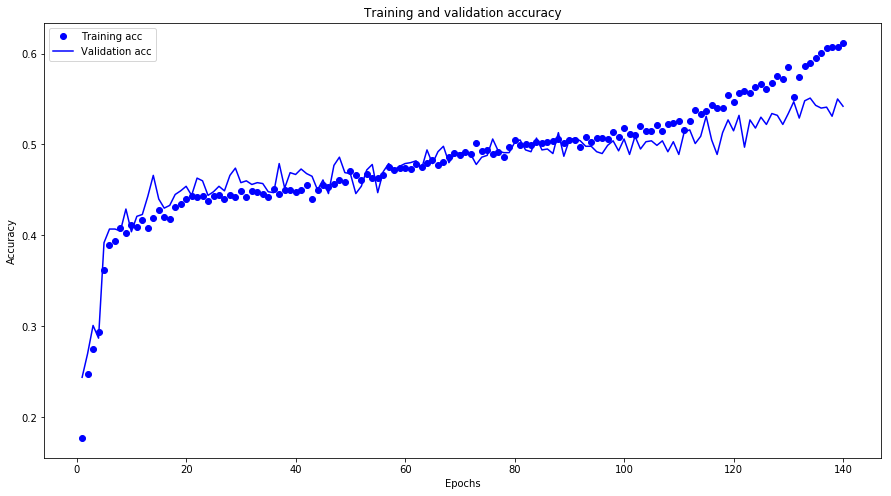

In [40]:
plt.clf()   # clear figure
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


history_50 = history

history_